In [1]:
import sys
import joblib
import os
import scipy.io as sio
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.inputs import GaussianInputs
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [3]:
project = 'kolmogorov'
tstep = 16710

In [4]:
L1, L2 = 2*np.pi, 2*np.pi
n1, n2 = 64, 64

grid_x = np.linspace(0,L1-L1/n1,n1)
grid_y = np.linspace(0,L2-L2/n2,n2)

grid_x, grid_y = np.meshgrid(grid_x, grid_y)

Kx = np.concatenate([np.arange(0, n1//2), np.arange(-n1//2, 0)]) * (2 * np.pi / L1)
Ky = np.concatenate([np.arange(0, n2//2), np.arange(-n2//2, 0)]) * (2 * np.pi / L2)

kx, ky = np.meshgrid(Kx,Ky)

dt_sim = 0.5
T_sim = 10000
nt = int(T_sim/dt_sim)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
u = np.load(f'{project_root}/data/{project}/u1.npy')
v = np.load(f'{project_root}/data/{project}/u2.npy')
w = np.load(f'{project_root}/data/{project}/vorticity.npy')

In [14]:
np.random.seed(1)

dt = 0.1
T = 1.5
dts = [dt for _ in range(int(T / dt))]

num_traj = 3
trajectories = {}
for traj_i in range(num_traj):
    if traj_i == 0:
        x0 = grid_x[n2//2, n1//2]
        y0 = grid_y[n2//2, n1//2]
    else:
        x0 = np.random.uniform(1, L1-1)
        y0 = np.random.uniform(1, L2-1)
    traj = generate_trajectory(u[tstep, :, :], v[tstep, :, :], grid_x, grid_y, x0, y0, dts)
    trajectories[traj_i] = traj


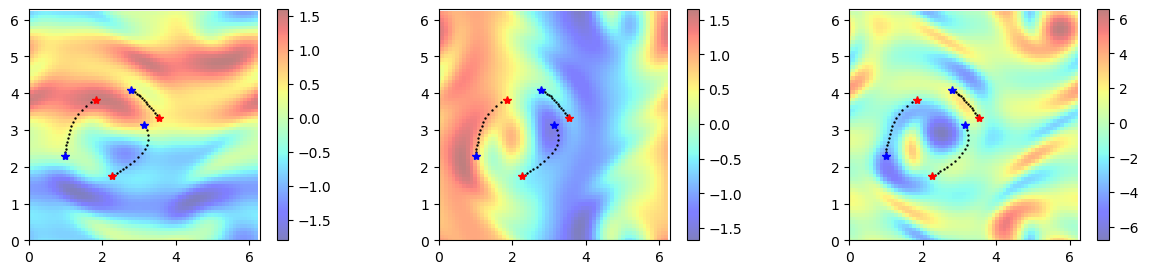

In [15]:
plt.figure(figsize=(15,3))

for i in range(3):
    if i == 0:
        plot_data = u[tstep,:,:]
    elif i == 1:
        plot_data = v[tstep,:,:]
    elif i == 2:
        plot_data = w[tstep,:,:]
        
    ax = plt.subplot(1,3,i+1)
    c = plot_trajectories(ax, plot_data, grid_x, grid_y, trajectories, 0, L1, 0, L2, cmap='jet')
    plt.colorbar(c)

In [ ]:
latent_dim = 50
nn = CNN_AE(latent_dim=latent_dim)

# nn.load_state_dict(torch.load(f"Kolmogorov_Models/CNN_AE_{latent_dim}.pth"))
nn.load_state_dict(torch.load(f'{project_root}/src/models/checkpoints/{project}/cnn_model.pth'))
nn.to(device)
D = nn.decode

data, nn_scaler = transform_data_for_AE(u,v)
latent_space = get_latent_space(nn, data)

latent_distribution = gaussian_kde(latent_space)

In [21]:
acquisition_function = 'LCB'
optimizer = GPOptimizer(trajectories, dts, trajectory_cost_function, D, latent_distribution, grid_x, grid_y, nn_scaler, device, acquisition_function)

In [22]:
optimizer.optimize(n_iterations=100)

Iteration 0: 12.204681454425986
Iteration 8: 9.601723400508183
Iteration 19: 8.69785565998608
Iteration 22: 6.1781428827823985
Iteration 48: 6.085867668065039
Iteration 52: 5.991064098456014
Iteration 60: 5.9620367157307514


 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in divide
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overf

In [25]:
z_opt, u_opt, v_opt, traj_opt = optimizer.get_optimal()
w_opt = vort(u_opt, v_opt, kx, ky)

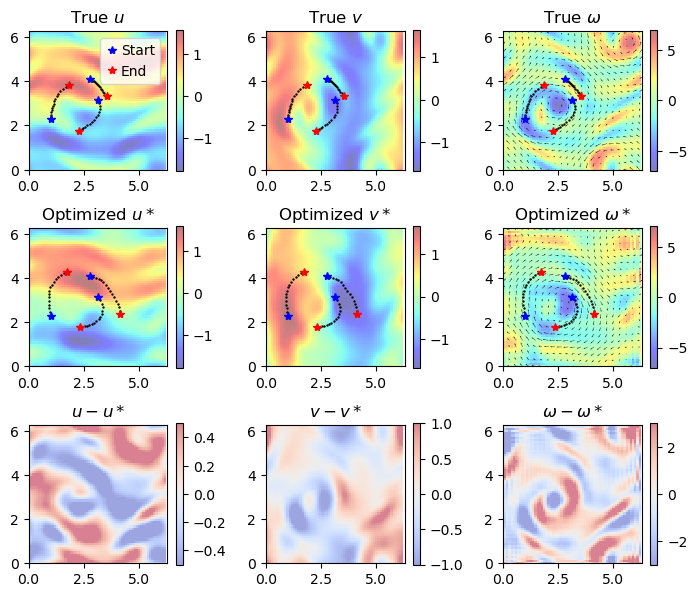

In [27]:
u_plot = u[tstep, :, :]
v_plot = v[tstep, :, :]
w_plot = w[tstep, :, :]

plot_configs = [
    {"data": u_plot, "traj": trajectories, "cmap": "jet", "vmin": u_plot.min(), "vmax": u_plot.max(), "title": "True $u$"},
    {"data": v_plot, "traj": trajectories, "cmap": "jet", "vmin": v_plot.min(), "vmax": v_plot.max(), "title": "True $v$"},
    {"data": w_plot, "traj": trajectories, "cmap": "jet", "vmin": -7, "vmax": 7, "title": "True $\omega$"},
    {"data": u_opt, "traj": traj_opt, "cmap": "jet", "vmin": u_plot.min(), "vmax": u_plot.max(), "title": "Optimized $u*$"},
    {"data": v_opt, "traj": traj_opt, "cmap": "jet", "vmin": v_plot.min(), "vmax": v_plot.max(), "title": "Optimized $v*$"},
    {"data": w_opt, "traj": traj_opt, "cmap": "jet", "vmin": -7, "vmax": 7, "title": "Optimized $\omega *$"},
    {"data": u_plot-u_opt, "traj": [], "cmap": "coolwarm", "vmin": -0.5, "vmax": 0.5, "title": "$u - u*$"},
    {"data": v_plot-v_opt, "traj": [], "cmap": "coolwarm", "vmin": -1, "vmax": 1, "title": "$v - v*$"},
    {"data": w_plot-w_opt, "traj": [], "cmap": "coolwarm", "vmin": -3, "vmax": 3, "title": "$\omega - \omega*$"},
]

fig = plt.figure(figsize=(7,6))

for i, cfg in enumerate(plot_configs):
    ax = plt.subplot(3, 3, i+1)
    c = plot_trajectories(ax, cfg["data"], grid_x, grid_y, cfg["traj"], 0, L1, 0, L2, cfg["vmin"], cfg["vmax"], cfg["cmap"])
    if i == 0:
        plt.legend(handlelength=1, handletextpad=0.1)
    if i == 2:
        plt.quiver(grid_x[::3,::3], grid_y[::3,::3], u_plot[::3,::3], v_plot[::3,::3], color='k')
    if i == 5:
        plt.quiver(grid_x[::3,::3], grid_y[::3,::3], u_opt[::3,::3], v_opt[::3,::3], color='k')
    plt.colorbar(c, shrink=0.95)
    plt.title(cfg["title"])

plt.tight_layout(pad=0.75)
